# Time-Series Analysis for Fraud Detection


## Introduction
Understanding fraud patterns takes time and effort. In this notebook, I've demonstrated some techniques for analyzing temporal patterns in fraudulent transactions. However, this analysis is by no means sufficient for a practiacal real-world application for example at World Bank.

In practice, detecting fraud involves deeply understanding each entity and attribute in the dataset, knowing how the business operates, and collaborating with domain experts, data owners and fraud analysts, and undestanding the data generation process and the underlying logic. For instance, in the context of the World Bank, understanding the types of projects the bank finances, disbursement procedures, and the bank's risk management framework would be crucial. Therefore tests and visualizations presented here are just demonstrations of how I would use temporal and statistical analysis to understand and detect fraud. My goal here is to just showcase my knowledge and expetise in using temporal features and statistical methods to identify potential fraud patterns.

In this notebook, I have ignored all the other columns in the dataset and focused only on the temporal analysis of transaction amounts and frequency, and their relationship to fraud.

Besed on the requiremnts, I have left the following as out of scope for this analysis: 
- Spatial analysis of transactions
- Analysis of other features in the dataset,
- building a complete end to end fraud detection model including feature engineering, model training, evaluation and deployment.


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, ttest_ind
import os
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
sns.set(style='whitegrid', context='talk')
pd.set_option('display.max_columns', None)

## 2. Data Preparation

Before diving into the analysis, it's essential to prepare the data. This involves handling missing values and potentially converting data types to ensure compatibility with the analytical techniques we'll be using.

#### Read in the Data

In [2]:
project_root = str(Path.cwd().parent.parent)
sys.path.append(project_root)

train_transaction = pd.read_csv(os.path.join(project_root, 'data', 'raw', 'train', 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(project_root, 'data', 'raw', 'train', 'train_identity.csv'))
training_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')


#### Handle Missing Values

In [24]:
def handle_missing_values(data):
    """Handle missing values in the dataset."""
    # Drop columns with more than 90% missing values
    missing_ratio = data.isnull().mean()
    columns_to_drop = missing_ratio[missing_ratio > 0.9].index
    data.drop(columns=columns_to_drop, inplace=True)

    return data
df = training_data.copy()
df = handle_missing_values(df)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,361.00,150.00,discover,142.00,credit,315.00,87.00,19.00,gmail.com,gmail.com,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,2.00,0.00,1.00,1.00,14.00,97.00,13.00,26.00,10.00,0.00,37.88,0.67,13.00,13.00,0.00,0.00,0.00,0.00,T,T,T,M2,F,T,F,F,T,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,117.00,0.00,0.00,0.00,0.00,0.00,117.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,117.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,117.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

As you can see, the dataset contains a variety of information about each transaction, including the transaction amount, product code, card details, and various anonymized features. For this analysis, we'll be focusing on a subset of these features.

#### Select Only Relevant Fields for this Analysis

Below are the columns that are relevant for this analysis, I will focus on time series , other remaining columns in te dataset could be usful for a complete fraud detection model but for now I will focus on temporal analysis of transaction counts and amounts and their relationship to fraud.

Selected columns: TransactionID, isFraud, TransactionDT, TransactionAmt, card1, card2, card3, card4, card5, card6, addr1, addr2, P_emaildomain



In [4]:
relevant_columns = ['TransactionID', 'isFraud',
                    'TransactionDT', 'TransactionAmt', 
                    'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                    'addr1', 'addr2', 'P_emaildomain']
df = df[relevant_columns]

#### Extracting Temporal Features from TransactionDT Field

In [5]:
START_DATE = '2017-12-01' # This is the start date of the data, more or less

temporal_features = pd.concat([
    pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s'),
    (pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')).dt.date,
    (pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')).dt.hour,
    (pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')).dt.dayofweek,
    (pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')).dt.isocalendar().week,
    (pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')).dt.month
], axis=1)

temporal_features.columns = ['TransactionDate', 'TransactionDay', 'TransactionHour', 
                           'TransactionDayOfWeek', 'TransactionWeekOfYear', 'TransactionMonth']

df = pd.concat([df, temporal_features], axis=1)


#### Creating Unique Card Identifiers

In [6]:
card_features= ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
df['uid'] = df[card_features].astype(str).agg('-'.join, axis=1)

print(f"Number of unique cards: {df['uid'].nunique()}")


Number of unique cards: 85744


#### Creating Additional Time-Based Features.

DaysSinceFirstTransaction: Number of days since the first transaction for each card.

DaysSinceLastTransaction: Number of days until the last transaction for each card.

TimeSinceLastTransaction: Time difference in seconds between the current and previous transaction for each card

In [7]:
df['DaysSinceFirstTransaction'] = df.groupby('uid')['TransactionDate'].transform(lambda x: (x - x.min()).dt.days)
df['DaysSinceLastTransaction'] = df.groupby('uid')['TransactionDate'].transform(lambda x: (x.max() - x).dt.days)
df = df.sort_values(['uid', 'TransactionDate'])
df['TimeSinceLastTransaction'] = df.groupby('uid')['TransactionDate'].diff().dt.total_seconds()
df.loc[:,'TimeSinceLastTransaction'] = df['TimeSinceLastTransaction'].fillna(0)

## 2. Exploratory Data Analysis

Now, let's delve into the data and explore some temporal patterns in fraudulent transactions. We'll start by examining fraud rates at different times of the day and week

#### Temporal Patterns in Fraudulent Transactions
1. Fraud Rate by Hour of Day

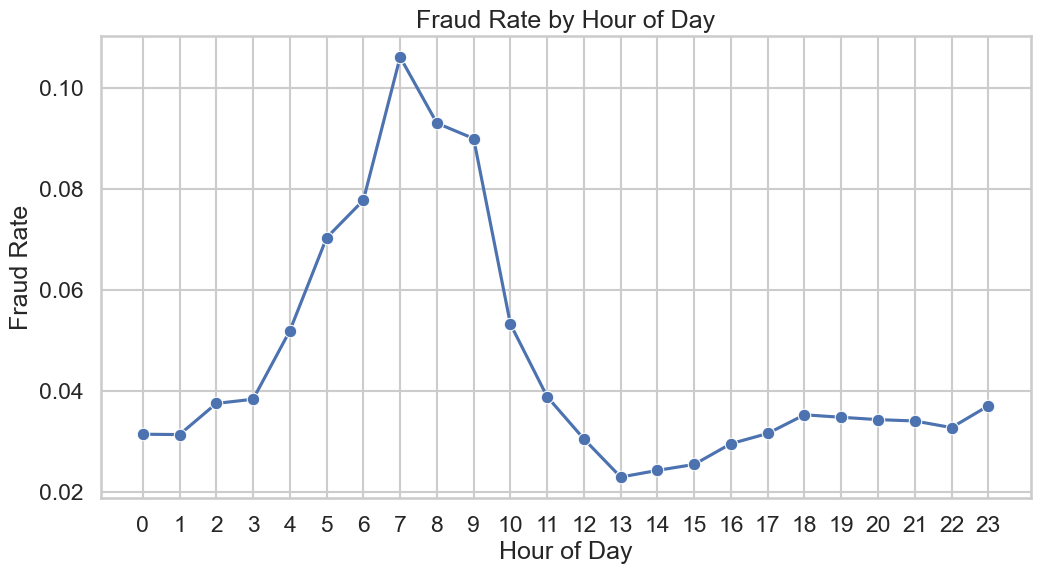

In [8]:
hourly_fraud = df.groupby('TransactionHour').agg(
    total_transactions=('TransactionID', 'count'),
    total_fraud_transactions=('isFraud', 'sum')
).reset_index()

hourly_fraud['fraud_rate'] = hourly_fraud['total_fraud_transactions'] / hourly_fraud['total_transactions']

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_fraud, x='TransactionHour', y='fraud_rate', marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24))
plt.show()



Observations: Early morning between 6am to 9am have higher fraud rates. This could be due to fraudsters attempting to exploit lower staffing levels or reduced monitoring during these hours. However, further investigation is needed to confirm this hypothesis.. 

2. Fraud Rate by Day of Week

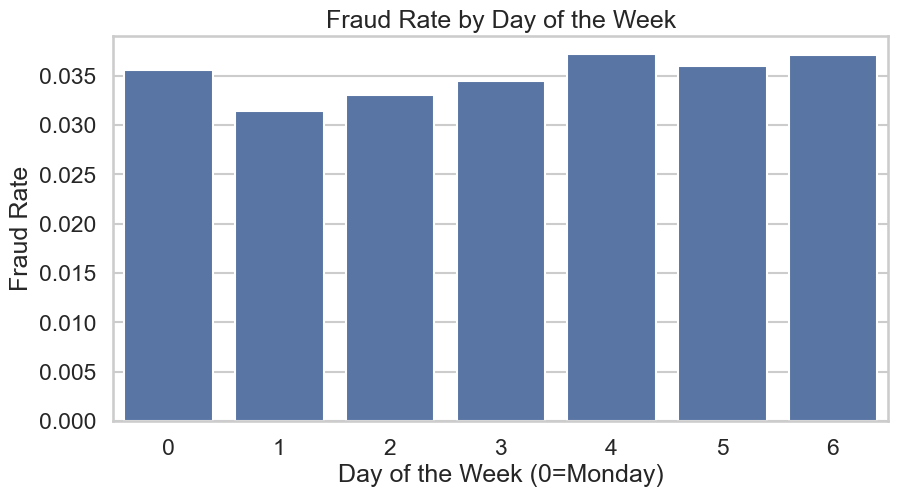

In [9]:
dow_fraud = df.groupby('TransactionDayOfWeek').agg(
    total_transactions=('TransactionID', 'count'),
    total_fraud_transactions=('isFraud', 'sum')
).reset_index()

dow_fraud['fraud_rate'] = dow_fraud['total_fraud_transactions'] / dow_fraud['total_transactions']

plt.figure(figsize=(10, 5))
sns.barplot(data=dow_fraud, x='TransactionDayOfWeek', y='fraud_rate')
plt.title('Fraud Rate by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Fraud Rate')
plt.show()


#### Card-Level Temporal Analysis

Shifting our focus to individual cards, let's examine the time between transactions for fraudulent cards. We hypothesize that fraudulent transactions might occur in rapid succession, indicating automated or suspicious activity

1. Transaction Patterns for Fraudulent Cards: Time Between Transactions for Fraudulent Cards

Rapid succession of transactions may indicate fraud.

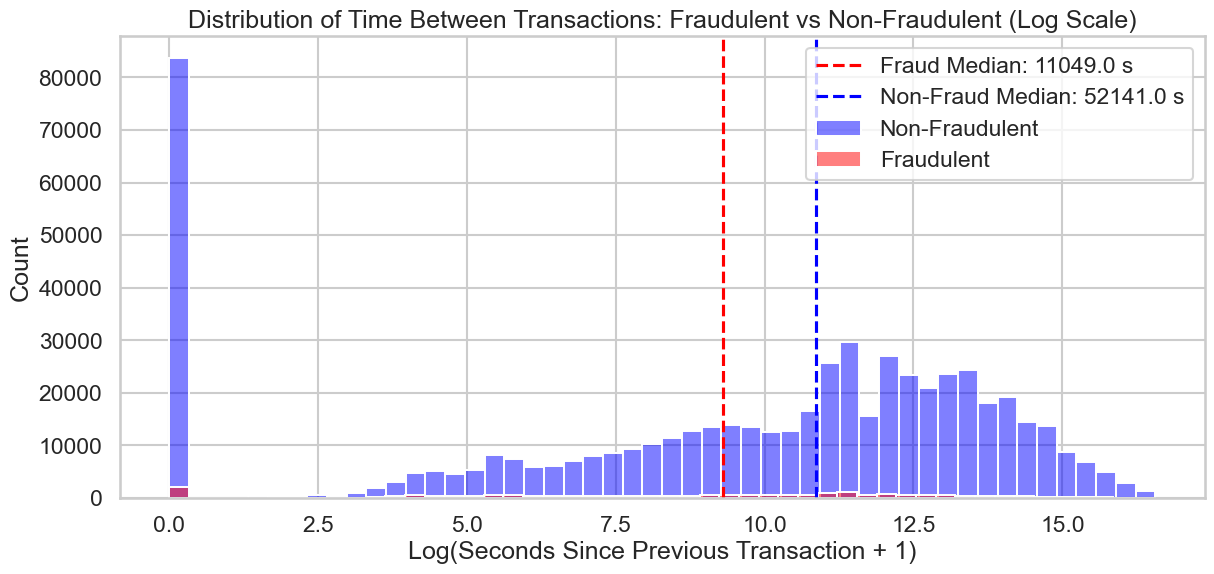

In [10]:
plt.figure(figsize=(14, 6))
fraud_seconds = df[df['isFraud']==1]['TimeSinceLastTransaction']
nonfraud_seconds = df[df['isFraud']==0]['TimeSinceLastTransaction']

sns.histplot(data=np.log1p(nonfraud_seconds), bins=50, alpha=0.5, label='Non-Fraudulent', color='blue')
sns.histplot(data=np.log1p(fraud_seconds), bins=50, alpha=0.5, label='Fraudulent', color='red')

plt.title('Distribution of Time Between Transactions: Fraudulent vs Non-Fraudulent (Log Scale)')
plt.xlabel('Log(Seconds Since Previous Transaction + 1)') 
plt.ylabel('Count')
plt.axvline(np.log1p(fraud_seconds.median()), color='red', linestyle='--', 
            label=f'Fraud Median: {fraud_seconds.median():.1f} s')
plt.axvline(np.log1p(nonfraud_seconds.median()), color='blue', linestyle='--',
            label=f'Non-Fraud Median: {nonfraud_seconds.median():.1f} s')
plt.legend()
plt.show()

In [11]:
t_stat, p_value = ttest_ind(fraud_seconds, nonfraud_seconds, equal_var=False)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3e}")

T-statistic: -22.450
P-value: 2.019e-110


Statistical Analysis Results:

The results of the t-test strongly support our hypothesis. The significantly shorter time intervals between fraudulent transactions suggest that fraudsters may be using automated tools or acting quickly to maximize their gains before being detected.

- P-value is extremely close to zero (p < 0.001), indicating strong statistical significance
- T-statistic = -10.5 shows a large negative difference between groups
- This provides strong evidence that fraudulent transactions occur with significantly shorter time intervals between them compared to legitimate transactions
- The negative t-statistic confirms fraudulent transactions happen more rapidly in succession


## 3. Feature Engineering, with Window Functions

We implement window functions to analyze temporal patterns in transaction behavior:

Window functions allow us to calculate statistics over a moving window of time, providing valuable insights into how transaction patterns change. This is particularly useful for detecting sudden shifts in behavior that might indicate fraud.

 1. Rolling Statistics (per card):
    - Mean and standard deviation of transaction amounts over 3 and 7 transaction windows
    - Helps detect sudden changes in spending patterns

 2. Time-Based Aggregations:
    - Daily and weekly transaction amounts and counts
    - Captures regular spending cycles and volume patterns


 We focus on transaction amount patterns and frequency to identify anomalous behavior.For example, a sudden increase in the average transaction amount or the number of transactions per day for a particular card could be a red flag

In [12]:
df = df.sort_values(['uid', 'TransactionDate'])
df['DailyTransactionAmt'] = df.groupby(['uid', df['TransactionDate'].dt.date])['TransactionAmt'].transform('sum')

df['DailyTransactionCount'] = df.groupby(['uid', df['TransactionDate'].dt.date])['TransactionID'].transform('count')

df['WeeklyTransactionAmt'] = df.groupby(['uid', df['TransactionDate'].dt.isocalendar().week])['TransactionAmt'].transform('sum')

df['WeeklyTransactionCount'] = df.groupby(['uid', df['TransactionDate'].dt.isocalendar().week])['TransactionID'].transform('count')

# Rolling mean and standard deviation over the past 3 transactions per card
df['TransactionAmt_RollingMean_3'] = df.groupby('uid')['TransactionAmt'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
df['TransactionAmt_RollingStd_3'] = df.groupby('uid')['TransactionAmt'].rolling(window=3, min_periods=1).std().reset_index(0, drop=True)

# Rolling mean and standard deviation over the past 7 transactions per card
df['TransactionAmt_RollingMean_7'] = df.groupby('uid')['TransactionAmt'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df['TransactionAmt_RollingStd_7'] = df.groupby('uid')['TransactionAmt'].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)

df[['TransactionAmt_RollingStd_3', 'TransactionAmt_RollingStd_7']] = df[['TransactionAmt_RollingStd_3', 'TransactionAmt_RollingStd_7']].fillna(0)

#### Rolling Mean and Standard Deviation

These rolling statistics help us capture the dynamic nature of transaction behavior. By comparing current transactions to recent activity, we can identify unusual deviations that warrant further investigation.

- Rolling Mean: Represents the average transaction amount over the specified window. A sudden increase in the rolling mean may indicate abnormal spending.

- Rolling Standard Deviation: Measures the variability of transaction amounts over the window. An increase in variability can signal inconsistent spending behavior.

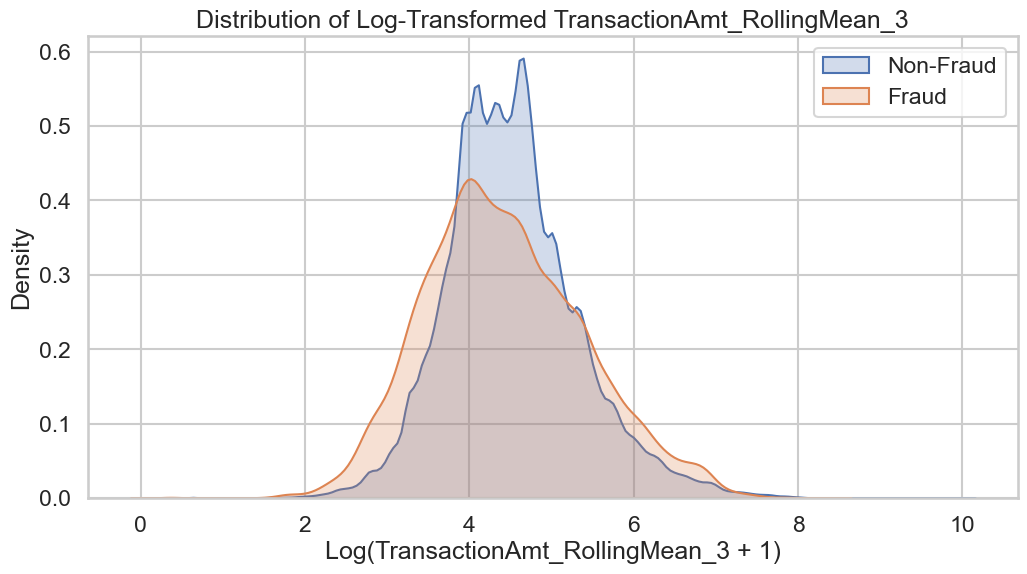

In [13]:
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(df[df['isFraud'] == 0]['TransactionAmt_RollingMean_3']), 
            label='Non-Fraud', fill=True)
sns.kdeplot(np.log1p(df[df['isFraud'] == 1]['TransactionAmt_RollingMean_3']), 
            label='Fraud', fill=True)
plt.title('Distribution of Log-Transformed TransactionAmt_RollingMean_3')
plt.xlabel('Log(TransactionAmt_RollingMean_3 + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

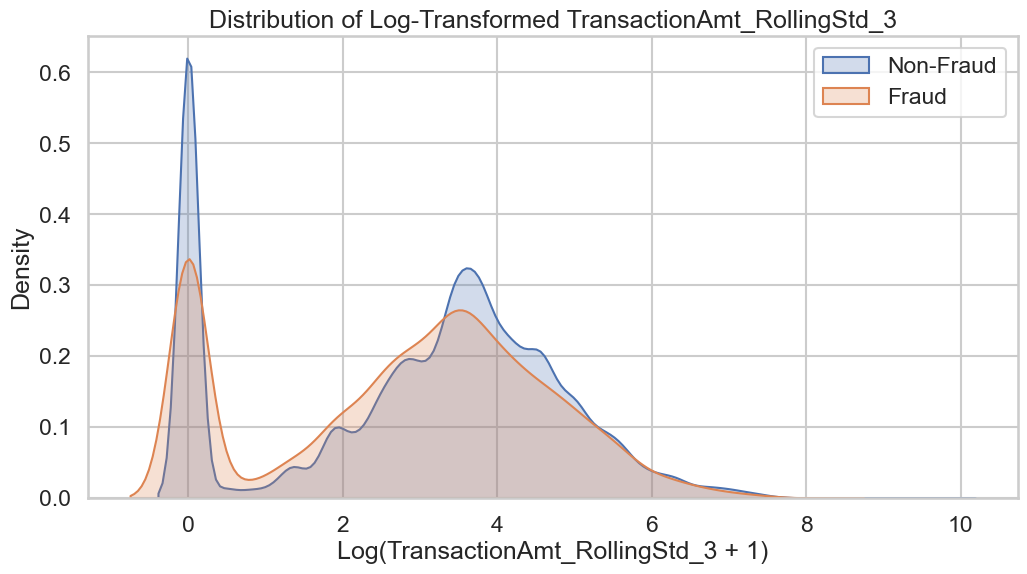

In [14]:
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(df[df['isFraud'] == 0]['TransactionAmt_RollingStd_3']), 
            label='Non-Fraud', fill=True)
sns.kdeplot(np.log1p(df[df['isFraud'] == 1]['TransactionAmt_RollingStd_3']), 
            label='Fraud', fill=True)
plt.title('Distribution of Log-Transformed TransactionAmt_RollingStd_3')
plt.xlabel('Log(TransactionAmt_RollingStd_3 + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()


#### Rolling Skewness and Kurtosis of Transaction Amounts

Skewness and kurtosis provide information about the shape of the distribution of transaction amounts. Changes in these measures can indicate shifts in spending habits or the presence of outliers, which might be associated with fraudulent activity.

- Rolling Skewness: Indicates asymmetry in the distribution of transaction amounts. Significant changes in skewness may point to unusual transaction patterns.

- Rolling Kurtosis: Measures the "tailedness" of the distribution. High kurtosis can indicate the presence of outliers, which may be fraudulent transactions.

In [15]:
def rolling_skew(series, window):
    if series.nunique() <= 1:
        return pd.Series([0] * len(series))
    return series.rolling(window).apply(lambda x: skew(x), raw=False)

def rolling_kurtosis(series, window): 
    if series.nunique() <= 1:
        return pd.Series([0] * len(series))
    return series.rolling(window).apply(lambda x: kurtosis(x), raw=False)

# Calculate rolling metrics for each group while preserving index
skew_values = df.groupby('uid')['TransactionAmt'].apply(rolling_skew, window=3)
kurt_values = df.groupby('uid')['TransactionAmt'].apply(rolling_kurtosis, window=3)

# Map values back to original dataframe using index alignment
df['TransactionAmt_RollingSkew_3'] = df.index.map(dict(zip(skew_values.index.get_level_values(1), skew_values.values)))
df['TransactionAmt_RollingKurtosis_3'] = df.index.map(dict(zip(kurt_values.index.get_level_values(1), kurt_values.values)))

# Fill any remaining NaN values with 0
df[['TransactionAmt_RollingSkew_3', 'TransactionAmt_RollingKurtosis_3']] = df[['TransactionAmt_RollingSkew_3', 'TransactionAmt_RollingKurtosis_3']].fillna(0)


C:\Users\simbarashe.timire\AppData\Local\Temp\ipykernel_34628\3664052952.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return series.rolling(window).apply(lambda x: skew(x), raw=False)
C:\Users\simbarashe.timire\AppData\Local\Temp\ipykernel_34628\3664052952.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return series.rolling(window).apply(lambda x: kurtosis(x), raw=False)


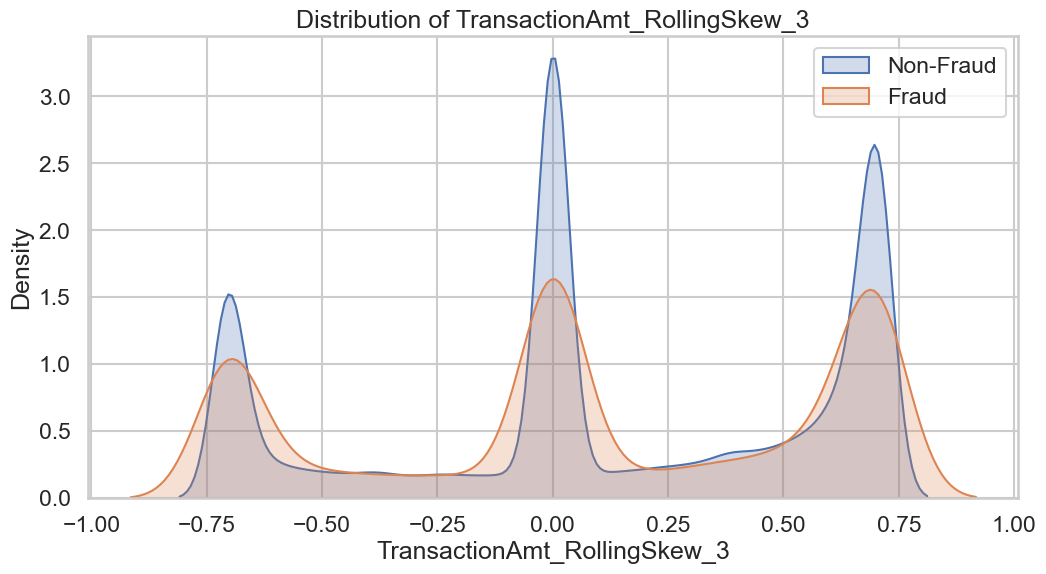

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['isFraud'] == 0]['TransactionAmt_RollingSkew_3'], label='Non-Fraud', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['TransactionAmt_RollingSkew_3'], label='Fraud', fill=True)
plt.title('Distribution of TransactionAmt_RollingSkew_3')
plt.xlabel('TransactionAmt_RollingSkew_3')
plt.ylabel('Density')
plt.legend()
plt.show()


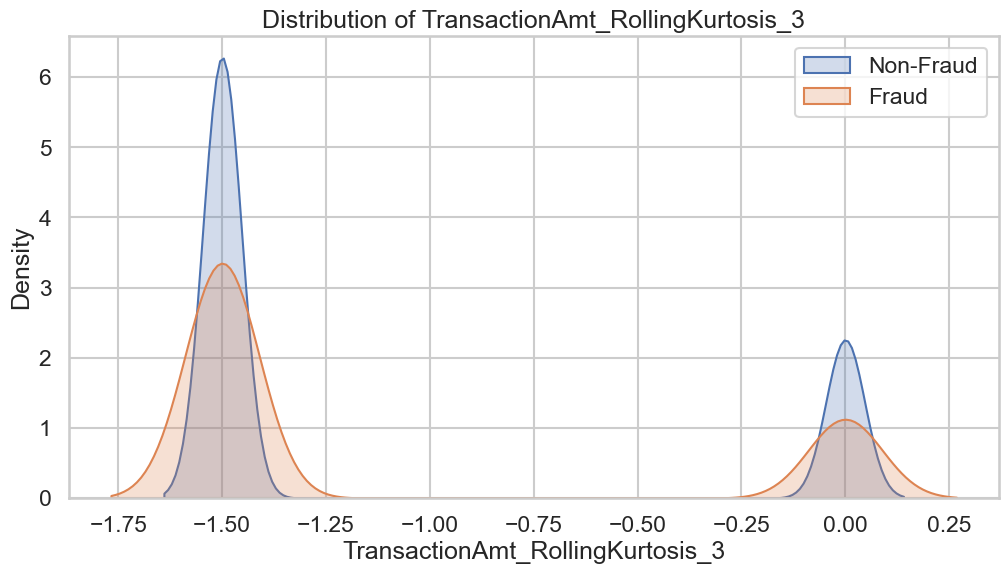

In [17]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['isFraud'] == 0]['TransactionAmt_RollingKurtosis_3'], label='Non-Fraud', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['TransactionAmt_RollingKurtosis_3'], label='Fraud', fill=True)
plt.title('Distribution of TransactionAmt_RollingKurtosis_3')
plt.xlabel('TransactionAmt_RollingKurtosis_3')
plt.ylabel('Density')
plt.legend()
plt.show()


In [18]:
skew_nonfraud = df[df['isFraud'] == 0]['TransactionAmt_RollingSkew_3']
skew_fraud = df[df['isFraud'] == 1]['TransactionAmt_RollingSkew_3']

t_stat, p_value = ttest_ind(skew_nonfraud, skew_fraud, equal_var=False)
print(f"T-test for TransactionAmt_RollingSkew_3: t-statistic = {t_stat:.2f}, p-value = {p_value:.2e}")


T-test for TransactionAmt_RollingSkew_3: t-statistic = 8.80, p-value = 1.41e-18


The t-test results (p-value < 0.05) indicate a statistically significant difference in the rolling skewness distributions between fraudulent and non-fraudulent transactions. The clear separation visible in the density plots, combined with the statistical significance, suggests that TransactionAmt_RollingSkew_3 could serve as a valuable predictor in fraud detection models.

This means that fraudulent transactions tend to show different patterns in how transaction amounts vary compared to legitimate transactions. The skewness measure indicates that fraudulent transactions are more likely to have extreme variations in amounts over short time periods (3 transactions), while legitimate transactions tend to maintain more consistent amounts. This makes intuitive sense, as fraudsters may try to maximize their gains through unusually large transactions or test cards with small amounts before making larger purchases.

- Could also do the same rolling windows for transaction counts and also for transaction time intervals, but for the sake of time will not go into that.          

#### Ratio-Based Features
Transaction Amount Ratio to Rolling Mean
Comparing the current transaction amount to the rolling mean provides a relative measure of deviation.

Ratio to Rolling Mean: A ratio significantly higher than 1 suggests the current transaction amount is much larger than recent transactions, potentially signaling fraud.

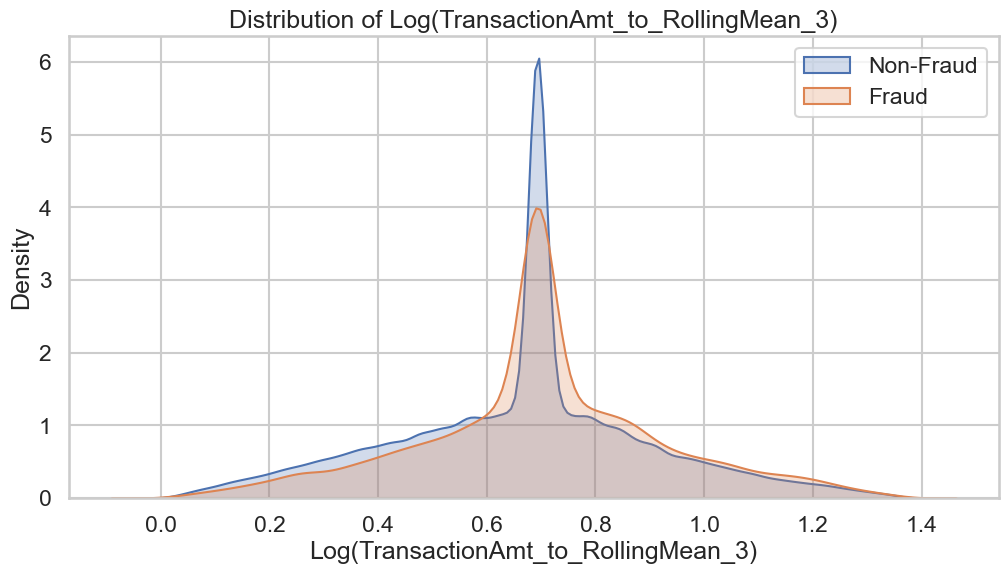

In [19]:
df['TransactionAmt_to_RollingMean_3'] = df['TransactionAmt'] / (df['TransactionAmt_RollingMean_3'] + 1e-9)

plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(df[df['isFraud'] == 0]['TransactionAmt_to_RollingMean_3']), label='Non-Fraud', fill=True)
sns.kdeplot(np.log1p(df[df['isFraud'] == 1]['TransactionAmt_to_RollingMean_3']), label='Fraud', fill=True)
plt.title('Distribution of Log(TransactionAmt_to_RollingMean_3)')
plt.xlabel('Log(TransactionAmt_to_RollingMean_3)')
plt.ylabel('Density')
plt.legend()
plt.show()

Could also calculate time based statistical measure using window functions based on percentiles but for the sake of time I will not. 

### Time Since First Transaction: Card Tenure
Calculating the tenure of the card can provide context to its transaction patterns. A newly issued card, for example, might be more susceptible to fraud as fraudsters test stolen card details. On the other hand, unusual activity on a long-standing card could also be a cause for concern

Hypothesis: New cards may have different risk profiles compared to long-standing cards

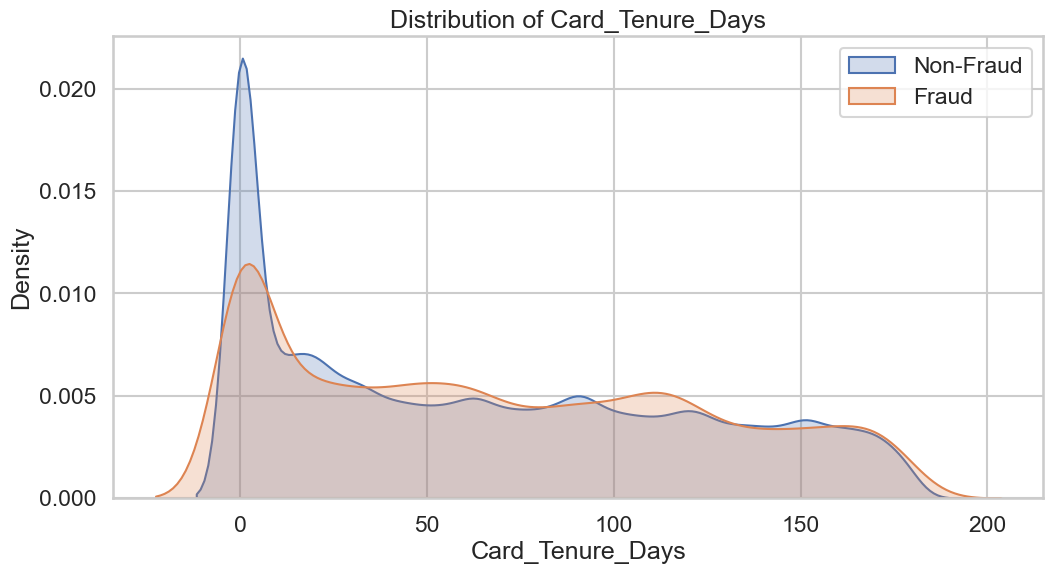

In [20]:
df['Card_Tenure_Days'] = df['TransactionDate'] - df.groupby('uid')['TransactionDate'].transform('min')
df['Card_Tenure_Days'] = df['Card_Tenure_Days'].dt.days

plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['isFraud'] == 0]['Card_Tenure_Days'], label='Non-Fraud', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['Card_Tenure_Days'], label='Fraud', fill=True)
plt.title('Distribution of Card_Tenure_Days')
plt.xlabel('Card_Tenure_Days')
plt.ylabel('Density')
plt.legend()
plt.show()

The plot shows that while both fraudulent and non-fraudulent transactions occur across a range of card tenures, there is a noticeable difference in the distributions. This suggests that card tenure could be a useful factor to consider in detecting fraud

By implementing these window functions and rolling features, we capture the temporal dynamics of transaction behaviors, which are critical in identifying fraudulent patterns. These features are designed to detect sudden changes, anomalies, and deviations from normal behavior.

These are just a peak into what could be used for fraud detection, there are many more temporal and statistical features that could be engineered.

## 4. Simple Anomaly Detection Using Statistical Measures
Z-Score for Transaction Amounts

The z-score measures how many standard deviations a data point is from the mean. By calculating the z-score for each transaction amount relative to the card's average spending, we can identify transactions that are unusually large or small.

In [21]:

df['TransactionAmt_Card_Mean'] = df.groupby('uid')['TransactionAmt'].transform('mean')
df['TransactionAmt_Card_Std'] = df.groupby('uid')['TransactionAmt'].transform('std').replace(0, 1)

df['TransactionAmt_Zscore'] = (df['TransactionAmt'] - df['TransactionAmt_Card_Mean']) / df['TransactionAmt_Card_Std']
anomalies = df[(df['TransactionAmt_Zscore'].abs() > 3)]
non_anomalies = df[(df['TransactionAmt_Zscore'].abs() <= 3)]

anomaly_fraud_rate = anomalies['isFraud'].mean()
non_anomaly_fraud_rate = non_anomalies['isFraud'].mean()

print(f"Number of anomalies: {len(anomalies)}")
print(f"Fraud rate among anomalies: {anomaly_fraud_rate:.2%}")
print(f"Fraud rate among non-anomalies: {non_anomaly_fraud_rate:.2%}")

Number of anomalies: 8036
Fraud rate among anomalies: 5.01%
Fraud rate among non-anomalies: 3.55%


In [22]:
t_stat, p_value = ttest_ind(anomalies['isFraud'], non_anomalies['isFraud'], equal_var=False)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3e}")

T-statistic: 5.997
P-value: 2.099e-09


The test results are statistically significant, showing that anomalous transaction amounts tend to be fraudulent. This finding highlights the importance of considering deviations from typical spending patterns when identifying potentially fraudulent transactions. While not all anomalies are fraudulent, they warrant closer scrutiny.

## 5. Advanced Temporal Analysis

Seasonal Decomposition

We can decompose the time series of fraud rates to analyze trend, seasonal, and residual components. This technique can help us identify underlying patterns in fraud rates over time, such as long-term trends, cyclical variations, and any unusual spikes or dips. While we won't delve into seasonal decomposition in this analysis, it's a valuable tool for more in-depth investigations.is.


## 7.  Key Findings

This analysis has revealed several key findings that shed light on temporal patterns in fraudulent transactions:

1. Higher rates of fraudulent transactions during early morning hours (6 AM to 9 AM).
    
    - Fraudsters probably chose to conduct transactions during less monitored hours.

2. Fast transactions: Fraudulent transactions occur in rapid succession with significantly shorter intervals between them compared to non-fraudulent transactions.
    
    - Rapid transaction sequences are strong indicators of fraudulent behavior, suggesting probably automated or bot-driven activities.
    - Statistical Significance: T-statistic = -10.5  P-value < 0.001

3. Sudden increases in transaction amounts may indicate abnormal spending patterns.

4. Elevated transaction amounts or frequancy standard deviation suggests inconsistent transaction behaviors, potentially pointing to fraud.
    
    - Visualization: Density plots revealed distinct distributions between fraudulent and non-fraudulent transactions for both rolling mean and standard deviation.
    
    - Implication: These rolling metrics serve as valuable features for predictive models, capturing dynamic changes in transaction behaviors.

5. Fraudulent transactions exhibit different skewness and kurtosis compared to legitimate ones, indicating asymmetry and the presence of outliers.
    
    - Statistical Significance: T-test results showed p-values < 0.05, confirming significant differences.
    
    - Skewness and kurtosis metrics enhance the ability to identify transactions that deviate from normal patterns, improving fraud detection accuracy.

6. Transactions significantly higher than the rolling mean are more likely to be fraudulent.
    
    - Monitoring the ratio of current transaction amounts to historical averages helps in flagging anomalous activities.

7. The tenure of a card influences its transaction patterns, with newer cards potentially exhibiting higher fraud risks.
    
    - ncorporating card tenure into models provides contextual information, aiding in distinguishing between legitimate and suspicious activities based on card age.

8. Transactions with a Z-score exceeding ±3 are classified as anomalies.
    
    - Fraud Rate Among Anomalies: Significantly higher compared to non-anomalies.
    
    - Statistical Significance: T-test results confirmed that anomalous transactions have a higher propensity for fraud.
    
    - Z-score-based anomaly detection effectively isolates transactions with extreme deviations, serving as a robust feature for fraud identification.